In [1]:
exec(open("init_notebook.py").read())

current working dirC:\Users\abjaw\Documents\GitHub\junction-art


In [2]:
import pyodrx, extensions
from library.Configuration import Configuration
import numpy as np
from junctions.RoadBuilder import RoadBuilder
from junctions.JunctionBuilder import JunctionBuilder
from junctions.AngleCurvatureMap import AngleCurvatureMap
from junctions.StandardCurveTypes import StandardCurveTypes
import math
from scipy.spatial import distance
from scipy.optimize import fsolve

from numpy import ones,vstack
from numpy.linalg import lstsq

In [3]:
roadBuilder = RoadBuilder()
junctionBuilder = JunctionBuilder()
configuration = Configuration()
angleCurvatureMap = AngleCurvatureMap()
esminiPath = configuration.get("esminipath")

{'test': 'This is nothing', 'test2': {'test22': 'this is something'}, 'esminipath': 'C:\\Users\\abjaw\\Documents\\GitHub\\esmini', 'rootPath': 'C:\\Users\\abjaw\\Documents\\GitHub\\junction-art'}


starting adjustment. May freeze!!!!!!!!!!!!!
start points starting
C:\Users\abjaw\Documents\GitHub\esmini\bin\odrplot.exe C:/Users/abjaw/Documents/GitHub/esmini/bin/pythonroad.xodr


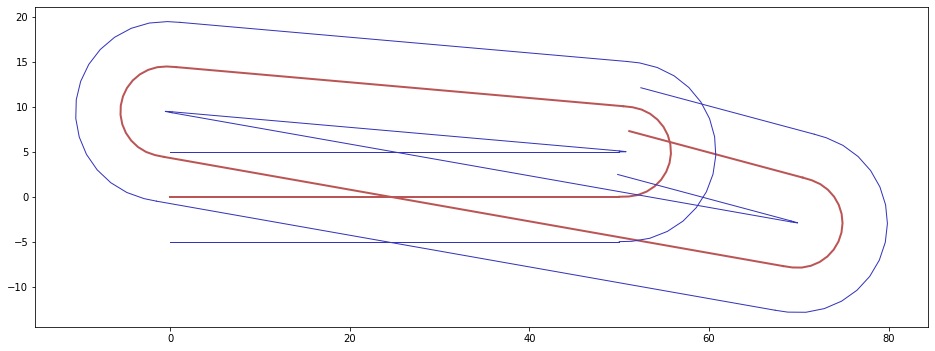

In [4]:
#creating roads

angle = 5
numberofLanes = 1
laneOffset = 10
curve, angle = angleCurvatureMap.getCurvatureForNonOverlappingRoads(angle, numberofLanes, laneOffset)
roads = []
roads.append(pyodrx.create_straight_road(0, 50,  n_lanes=numberofLanes, lane_offset=laneOffset))
roads.append(roadBuilder.createSimpleCurveWithLongArcWithLaneNumberandOffset(1, angle, False, curvature = curve, _n_lanes = numberofLanes, _lane_offset=laneOffset))
roads.append(pyodrx.create_straight_road(2, 50, n_lanes=numberofLanes, lane_offset=laneOffset))
roads.append(roadBuilder.createSimpleCurveWithLongArcWithLaneNumberandOffset(3, angle, False, curvature = curve, _n_lanes = numberofLanes, _lane_offset=laneOffset))
roads.append(pyodrx.create_straight_road(4, 70, n_lanes=numberofLanes, lane_offset=laneOffset))
roads.append(roadBuilder.createSimpleCurveWithLongArcWithLaneNumberandOffset(5, angle, False, curvature = curve, _n_lanes = numberofLanes, _lane_offset=laneOffset))
roads.append(pyodrx.create_straight_road(6, 20, n_lanes=numberofLanes, lane_offset=laneOffset))


roads[0].add_successor(pyodrx.ElementType.road,1,pyodrx.ContactPoint.start)

roads[1].add_predecessor(pyodrx.ElementType.road,0,pyodrx.ContactPoint.end)
roads[1].add_successor(pyodrx.ElementType.road,2,pyodrx.ContactPoint.start)

roads[2].add_predecessor(pyodrx.ElementType.road,1,pyodrx.ContactPoint.end)
roads[2].add_successor(pyodrx.ElementType.road,3,pyodrx.ContactPoint.start)

roads[3].add_predecessor(pyodrx.ElementType.road,2,pyodrx.ContactPoint.end)
roads[3].add_successor(pyodrx.ElementType.road,4,pyodrx.ContactPoint.start)

roads[4].add_predecessor(pyodrx.ElementType.road,3,pyodrx.ContactPoint.end)
roads[4].add_successor(pyodrx.ElementType.road,5,pyodrx.ContactPoint.start)

roads[5].add_predecessor(pyodrx.ElementType.road,4,pyodrx.ContactPoint.end)
roads[5].add_successor(pyodrx.ElementType.road,6,pyodrx.ContactPoint.start)

roads[6].add_predecessor(pyodrx.ElementType.road,5,pyodrx.ContactPoint.end)

odrName = "curve_test"

odr = extensions.createOdr(odrName, roads, [])
extensions.view_road(odr, esminiPath)

In [ ]:
def find_intersection(road1, road2):
    if (road1.curveType == StandardCurveTypes.Line and road2.curveType == StandardCurveTypes.Line):
        intersection = isCollidingStraightRoads(road1, road2)
        return intersection
    if (road1.curveType == StandardCurveTypes.Line and road2.curveType == StandardCurveTypes.LongArc):
        

In [5]:
#for StandardCurveTypes.Line

def perp(a):
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2):
    da = [a2[0]-a1[0], a2[1]-a1[1]]
    db = [b2[0]-b1[0], b2[1]-b1[1]]
    dp = [a1[0]-b1[0], a1[1]-b1[1]]
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db[0] + b1[0], (num / denom.astype(float))*db[1] + b1[1]

def isCollidingStraightRoads(road1, road2):
    p1, p2, p3, p4 = [[], []], [[], []], [[], []], [[], []]
    p1[0], p1[1], _ = road1.getAdjustedStartPosition()
    p2[0], p2[1], _ = road1.getAdjustedEndPosition()
    
    p3[0], p3[1], _ = road2.getAdjustedStartPosition()
    p4[0], p4[1], _ = road2.getAdjustedEndPosition()
    
    intersection = seg_intersect(p1,p2,p3,p4) 
    
    segmentLength_r1 = distance.euclidean(p1, p2)
    distanceIntersectionandStart_r1 = distance.euclidean(intersection, p1)
    distanceIntersectionandEnd_r1 = distance.euclidean(intersection, p2)
    
    segmentLength_r2 = distance.euclidean(p3, p4)
    distanceIntersectionandStart_r2 = distance.euclidean(intersection, p3)
    distanceIntersectionandEnd_r2 = distance.euclidean(intersection, p4)
    
#     print(segmentLength_r1, distanceIntersectionandStart_r1, distanceIntersectionandEnd_r1)
#     print(segmentLength_r2, distanceIntersectionandStart_r2, distanceIntersectionandEnd_r2)
    
    if(
        (round((distanceIntersectionandEnd_r1 + distanceIntersectionandStart_r1), 2) == round(segmentLength_r1, 2))
        and (round((distanceIntersectionandEnd_r2 + distanceIntersectionandStart_r2), 2) == round(segmentLength_r2, 2))
    ):
        if (distanceIntersectionandEnd_r1 == 0 and distanceIntersectionandStart_r2 == 0):
            return None
        return intersection
    else:
        return None  

def findCenterAndRadius(road1, road2):
    x1, y1, _ = road1.getAdjustedEndPosition()
    x2, y2, _ = road2.getAdjustedStartPosition()
    r = math.sqrt((x1 - x2)**2 + (y1 - y2)**2) / 2
    return (x1 + x2)/2, (y1 + y2)/2, r

def isCollidingArcAndStraightRoad(arc, line):
    h, k, r = arc
    m, c = line
    def f(xy):
        x, y = xy
        z = np.array([(x-h) **2 + (y-k)**2 - r**2, y-m*x-c])
        return z
    return fsolve(f, [h - r, h + r])

def lineEquTwoPointsToMC(road):
    points = [[0, 0], [0, 0]]
    points[0][0], points[0][1], _ = road.getAdjustedStartPosition()
    points[1][0], points[1][1], _ = road.getAdjustedEndPosition()
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    return m, c
    

In [6]:
isCollidingArcAndStraightRoad(findCenterAndRadius(roads[0], roads[2]), lineEquTwoPointsToMC(roads[6]))

C:\Users\abjaw\Anaconda3\envs\opendrive\lib\site-packages\ipykernel_launcher.py:70: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


array([55.12465652,  6.23798465])

In [7]:
roads[1].getAdjustedStartPosition()

(51.951417771065415, 9.87612939583271, 2.9016098822041543)

In [8]:
roads[1].getAdjustedEndPosition()

(50.4403745882497, 10.086236499491424, 3.0543261925172396)

In [9]:
roads[0].getAdjustedEndPosition()

(50.0, 0.0, 0)